# MODIS_L1B_LST反演

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from pyhdf import SD
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import cm

In [2]:
# 数据所在目录
hdf_L1B=glob.glob('C:\\Users\Lenovo\Documents\MOD021KM.A2019123.0325*.hdf')
print("MODIS L1B file found {}".format(hdf_L1B))
hdf_GEO=glob.glob('C:\\Users\Lenovo\Documents\MOD03.A2019123.0325*.hdf')
print("MODIS Geolocation file found {}".format(hdf_GEO))

MODIS L1B file found ['C:\\Users\\Lenovo\\Documents\\MOD021KM.A2019123.0325.061.2019123131709.hdf']
MODIS Geolocation file found ['C:\\Users\\Lenovo\\Documents\\MOD03.A2019123.0325.061.2019123083843.hdf']


In [3]:
L1B_obj=SD.SD(hdf_L1B[0], SD.SDC.READ)
GEO_obj=SD.SD(hdf_GEO[0], SD.SDC.READ)
print(L1B_obj.datasets().keys())

dict_keys(['Latitude', 'Longitude', 'EV_1KM_RefSB', 'EV_1KM_RefSB_Uncert_Indexes', 'EV_1KM_Emissive', 'EV_1KM_Emissive_Uncert_Indexes', 'EV_250_Aggr1km_RefSB', 'EV_250_Aggr1km_RefSB_Uncert_Indexes', 'EV_250_Aggr1km_RefSB_Samples_Used', 'EV_500_Aggr1km_RefSB', 'EV_500_Aggr1km_RefSB_Uncert_Indexes', 'EV_500_Aggr1km_RefSB_Samples_Used', 'Height', 'SensorZenith', 'SensorAzimuth', 'Range', 'SolarZenith', 'SolarAzimuth', 'gflags', 'EV_Band26', 'EV_Band26_Uncert_Indexes', 'Band_250M', 'Band_500M', 'Band_1KM_RefSB', 'Band_1KM_Emissive', 'Noise in Thermal Detectors', 'Change in relative responses of thermal detectors', 'DC Restore Change for Thermal Bands', 'DC Restore Change for Reflective 250m Bands', 'DC Restore Change for Reflective 500m Bands', 'DC Restore Change for Reflective 1km Bands'])


In [4]:
# 找到对应的热红外和红色波段所在数据集
raw_C31=L1B_obj.select('EV_1KM_Emissive')[:]# 热红外波段所在
raw_C1=L1B_obj.select('EV_250_Aggr1km_RefSB')[:]# 红色波段所在

In [5]:
# 检查数据大小
print("Size of 'EV_1KM_Emissive': {}".format(raw_C31.shape))
print("Size of 'EV_250_Aggr1km_RefSB': {}".format(raw_C1.shape))
print("Attributies of 'EV_1KM_Emissive'\n===============================")
print(L1B_obj.select('EV_1KM_Emissive').attributes())
print("Attributies of 'EV_500_Aggr1km_RefSB'\n===============================")
print(L1B_obj.select('EV_250_Aggr1km_RefSB').attributes())

Size of 'EV_1KM_Emissive': (16, 2030, 1354)
Size of 'EV_250_Aggr1km_RefSB': (2, 2030, 1354)
Attributies of 'EV_1KM_Emissive'
{'long_name': 'Earth View 1KM Emissive Bands Scaled Integers', 'units': 'none', 'valid_range': [0, 32767], '_FillValue': 65535, 'band_names': '20,21,22,23,24,25,27,28,29,30,31,32,33,34,35,36', 'radiance_scales': [6.262398528633639e-05, 0.0031495101284235716, 6.921597378095612e-05, 7.910397835075855e-05, 3.155614103889093e-05, 5.639820665237494e-05, 0.00011755729792639613, 0.0001924497337313369, 0.000532486941665411, 0.0004063234373461455, 0.0008400219958275557, 0.000729697581846267, 0.00026226387126371264, 0.00020069582387804985, 0.0001767082721926272, 0.0001183385684271343], 'radiance_offsets': [2730.58349609375, 2730.58349609375, 2730.58349609375, 2730.58349609375, 1077.44482421875, 1560.3333740234375, 2730.583251953125, 2317.48828125, 2730.58349609375, 1560.333251953125, 1577.3397216796875, 1658.2213134765625, 2501.297607421875, 2501.297607421875, 2501.2978515

In [6]:
# 选择参数
band_names=L1B_obj.select('EV_1KM_Emissive').attributes()['band_names']
radiance_scales=L1B_obj.select('EV_1KM_Emissive').attributes()['radiance_scales']
radiance_offsets=L1B_obj.select('EV_1KM_Emissive').attributes()['radiance_offsets']

In [7]:
# 构建参数的矩阵
band_names=np.fromstring(band_names, dtype=np.float, sep=',')
radiance_scales=np.array(radiance_scales)
radiance_offsets=np.array(radiance_offsets)

In [8]:
# 热红外波段辐射定标
hit=band_names==31
raw_C31=raw_C31[hit, :, :]
C31=(raw_C31 - radiance_offsets[hit] * np.ones(raw_C31.shape)) * radiance_scales[hit]

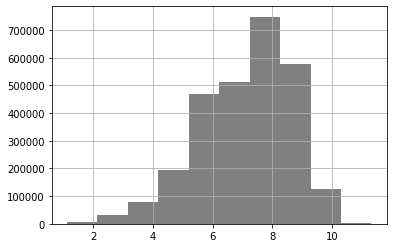

In [9]:
# 查看辐射定标结果
plt.hist(C31.flat, color='gray')
plt.grid()

In [10]:
# 同样方法对第1波段（红色波段）辐射定标
band_names=L1B_obj.select('EV_250_Aggr1km_RefSB').attributes()['band_names']
reflectance_scales=L1B_obj.select('EV_250_Aggr1km_RefSB').attributes()['reflectance_scales']
reflectance_offsets=L1B_obj.select('EV_250_Aggr1km_RefSB').attributes()['reflectance_offsets']

In [11]:
band_names=np.fromstring(band_names, dtype=np.float, sep=',')
reflectance_scales=np.array(reflectance_scales)
reflectance_offsets=np.array(reflectance_offsets)

In [12]:
hit=band_names==1
raw_C1=raw_C1[hit, :, :]
C1=(raw_C1 - reflectance_offsets[hit] * np.ones(raw_C1.shape)) * reflectance_scales[hit]

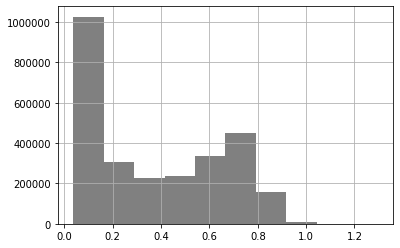

In [13]:
plt.hist(C1.flat, color='gray')
plt.grid()

In [14]:
print(GEO_obj.datasets().keys())# 查看地理校正文件属性

dict_keys(['Latitude', 'Longitude', 'Scan Offset', 'Track Offset', 'Height Offset', 'Height', 'SensorZenith', 'SensorAzimuth', 'Range', 'SolarZenith', 'SolarAzimuth', 'Land/SeaMask', 'WaterPresent', 'gflags', 'Scan number', 'EV frames', 'SD frames', 'SV frames', 'EV start time', 'SD start time', 'SV start time', 'EV center time', 'Mirror side', 'SD Sun zenith', 'SD Sun azimuth', 'Moon Vector', 'L1 scan quality', 'Geo scan quality', 'orb_pos', 'orb_vel', 'T_inst2ECR', 'attitude_angles', 'sun_ref', 'num_impulse', 'impulse_enc', 'impulse_time', 'Scan Type', 'thermal_correction', 'attitude_quality', 'ephemeris_quality', 'Focal_length', 'band_position', 'detector_space', 'detector_offsets', 'T_offset', 'num_samples'])


In [15]:
C_x=GEO_obj.select('Longitude')[:]
C_y=GEO_obj.select('Latitude')[:]

In [16]:
# 检查数据大小
print("Size of 'Longitude': {}".format(C_x.shape))
print("Size of 'Latitude': {}".format(C_y.shape))

Size of 'Longitude': (2030, 1354)
Size of 'Latitude': (2030, 1354)


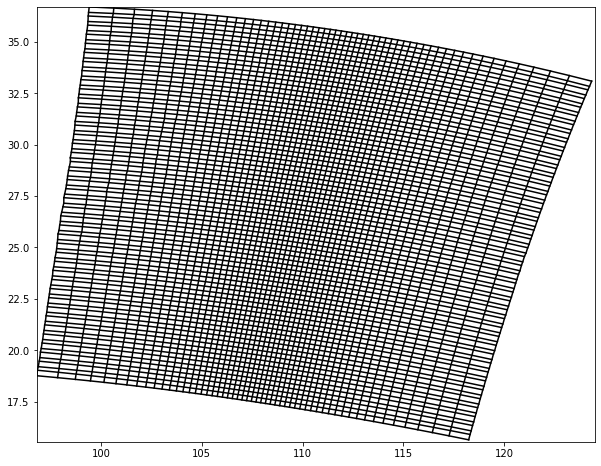

In [17]:
# 绘制经纬网.
fig=plt.figure(figsize=(10, 8))
axis=plt.gca()
axis.set_xlim(C_x.min(), C_x.max())
axis.set_ylim(C_y.min(), C_y.max())
axis.plot(C_x[::25, ::25], C_y[::25, ::25], 'k-');
axis.plot(C_x[::25, ::25].T, C_y[::25, ::25].T, 'k-');

In [18]:
# 定义新的投影模型
def reproj_L1B(raw_data, raw_x, raw_y, xlim, ylim, res):
    
    '''
    =======================================================================
    Reproject MODIS L1B file to a regular grid
                            ----- created on 2014/12/18, Yingkai (Kyle) Sha
    -----------------------------------------------------------------------
    d_array, x_array, y_array, bin_count = reproj_L1B(...)
    -----------------------------------------------------------------------
    Input:
            raw_data: L1B data, N*M 2-D array.
            raw_x: longitude info. N*M 2-D array.
            raw_y: latitude info. N*M 2-D array.
            xlim: range of longitude, a list.
            ylim: range of latitude, a list.
            res: resolution, res=[res_lon, res_lat].
    Output:
            d_array: L1B reprojected data.
            x_array: reprojected longitude.
            y_array: reprojected latitude.
            bin_count: how many raw data point included in a reprojected grid.
    Note:
            function do not performs well if "res" is higher than the resolution of input data. 
            Size of "raw_data", "raw_x", "raw_y" must agree.
    =======================================================================
    '''
    import numpy as np
    
    x_bins=np.arange(xlim[0], xlim[1], res[0])
    y_bins=np.arange(ylim[0], ylim[1], res[1])
#    x_indices=np.digitize(raw_x.flat, x_bins)
#    y_indices=np.digitize(raw_y.flat, y_bins)
    x_indices=np.searchsorted(x_bins, raw_x.flat, 'right')
    y_indices=np.searchsorted(y_bins, raw_y.flat, 'right')
        
    y_array=np.zeros([len(y_bins), len(x_bins)], dtype=np.float)
    x_array=np.zeros([len(y_bins), len(x_bins)], dtype=np.float)
    d_array=np.zeros([len(y_bins), len(x_bins)], dtype=np.float)
    bin_count=np.zeros([len(y_bins), len(x_bins)], dtype=np.int)
    
    for n in range(len(y_indices)):
        bin_row=y_indices[n]-1
        bin_col=x_indices[n]-1
        bin_count[bin_row, bin_col] += 1
        x_array[bin_row, bin_col] += raw_x.flat[n]
        y_array[bin_row, bin_col] += raw_y.flat[n]
        d_array[bin_row, bin_col] += raw_data.flat[n]
                   
    for i in range(x_array.shape[0]):
        for j in range(x_array.shape[1]):
            if bin_count[i, j] > 0:
                x_array[i, j]=x_array[i, j]/bin_count[i, j]
                y_array[i, j]=y_array[i, j]/bin_count[i, j]
                d_array[i, j]=d_array[i, j]/bin_count[i, j] 
            else:
                d_array[i, j]=np.nan
                x_array[i, j]=np.nan
                y_array[i,j]=np.nan
                
    return d_array, x_array, y_array, bin_count

In [19]:
# 对C31进行地理校正
xlim=[np.min(C_x), np.max(C_x)]
ylim=[np.min(C_y), np.max(C_y)]
C31_grid, longitude, latitude, bin_count = reproj_L1B(C31, C_x, C_y, xlim, ylim, res=[0.5, 0.5])

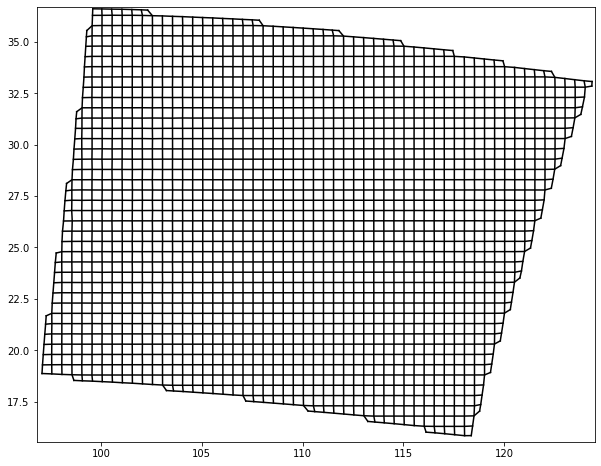

In [20]:
# 绘制经地理校正的C31数据
fig=plt.figure(figsize=(10, 8))
axis=plt.gca()
axis.set_xlim(xlim)
axis.set_ylim(ylim)
axis.plot(longitude, latitude, 'k-');
axis.plot(longitude.T, latitude.T, 'k-');
res=[0.05, 0.05];
xlim=[np.min(C_x), np.max(C_x)]
ylim=[np.min(C_y), np.max(C_y)]
C31_grid, longitude, latitude, bin_count = reproj_L1B(C31, C_x, C_y, xlim, ylim, res)
C1_grid, longitude, latitude, bin_count = reproj_L1B(C1, C_x, C_y, xlim, ylim, res)

In [21]:
#开始制作云掩膜
C31_bins = 100
C31_lim=[np.nanmin(C31_grid), np.nanmax(C31_grid)]
C31_bins=np.linspace(C31_lim[0], C31_lim[1], C31_bins, dtype=np.float)
C1_bins = 150 
C1_lim=[np.nanmin(C1_grid), np.nanmax(C1_grid)]
C1_bins=np.linspace(C1_lim[0], C1_lim[1], C1_bins, dtype=np.float)
y=C31_grid.flat[:]; y_bins=C31_bins # x: C31
x=C1_grid.flat[:]; x_bins=C1_bins # y: C1
H, y_edges, x_edges = np.histogram2d(y, x, bins=(y_bins, x_bins))
X, Y = np.meshgrid(x_edges[:-1], y_edges[:-1])

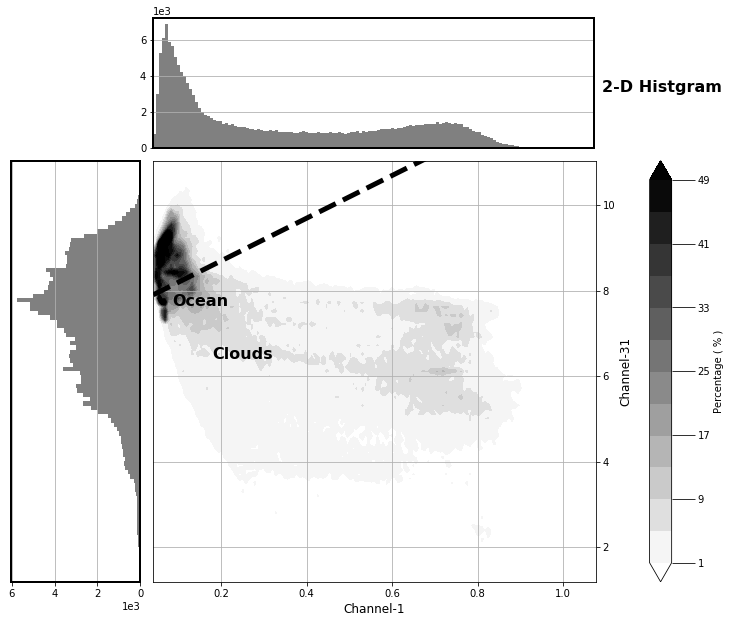

In [22]:
#2维散点图和设置分割线区分云
from mpl_toolkits.axes_grid1 import make_axes_locatable
left=0.1; width = 0.8; bottom=0.1; height = 0.65
gap=0.02; hist_len=0.2; cbar_len=0.12
rect_main  = [left+hist_len+gap, bottom, width, height]
rect_histx = [left+hist_len+gap, left+height+gap, width-cbar_len, hist_len]
rect_histy = [left, bottom, hist_len, height]
clevs=np.arange(1, 50, 4)
CMap=plt.cm.gray_r
CMap.set_over(CMap(np.arange(256))[-1, 0:3])
CMap.set_under('w')
xlim_bin=[np.min(X), np.max(X)]
ylim_bin=[np.min(Y), np.max(Y)]
fig=plt.figure(figsize=(9, 9))
axMain=plt.axes(rect_main)
axMain.yaxis.tick_right()
axMain.yaxis.set_label_position('right')
axMain.set_xlim(xlim_bin)
axMain.set_ylim(ylim_bin)
axMain.set_xlabel('Channel-1', fontsize=12)
axMain.set_ylabel('Channel-31', fontsize=12)
axMain.set_title('2-D Histgram', fontsize=16, fontweight='bold', x=1.15, y=1.15)
divider=make_axes_locatable(axMain)
plt.grid() 
CS=axMain.contourf(X, Y, H/np.max(H)*100, clevs, cmap=CMap, extend='both') 
CAx=divider.append_axes('right', size='5%', pad=0.75)
CBar=plt.colorbar(CS, cax=CAx)
CBar.set_label('Percentage ( % )', fontsize=10)
CBar.ax.tick_params(axis='y', length=22.5)
axMain.plot(x_edges, x_edges*5+7.7*np.ones(x_edges.shape),color='k', linestyle='--', linewidth=5)
axMain.text(0.25, 6.5, 'Clouds', fontsize=16, fontweight='bold',ha='center', va='center', color='k')
axMain.text(0.15, 7.75, 'Ocean', fontsize=16, fontweight='bold',ha='center', va='center', color='k')
axHistx=plt.axes(rect_histx)
axHistx.hist(x, bins=x_bins, color=[0.5, 0.5, 0.5])
axHistx.set_xlim(xlim_bin)
axHistx.axes.get_xaxis().set_visible(False)
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
[i.set_linewidth(2) for i in axHistx.spines.values()]
plt.grid()
axHisty = plt.axes(rect_histy)
axHisty.hist(y, bins=y_bins, color=[0.5, 0.5, 0.5], orientation='horizontal')
axHisty.set_ylim(ylim_bin)
axHisty.invert_xaxis()
axHisty.axes.get_yaxis().set_visible(False)
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
[i.set_linewidth(2) for i in axHisty.spines.values()]
plt.grid()

Text(0.125, 7.75, 'No-Cloud')

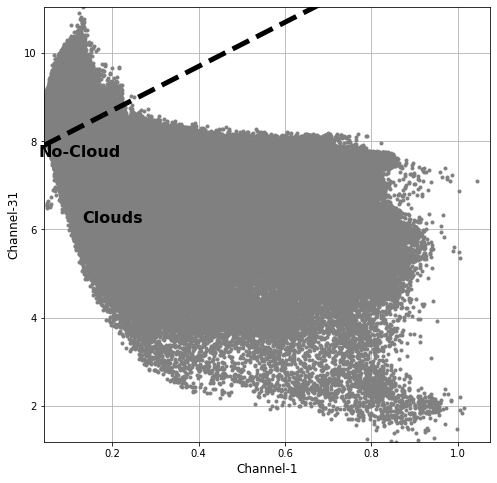

In [23]:
#绘制散点图
fig=plt.figure(figsize=(8, 8))
ax=plt.gca()
plt.grid()
ax.set_xlim(xlim_bin[0], xlim_bin[1])
ax.set_ylim(ylim_bin[0], ylim_bin[1])
ax.set_xlabel('Channel-1', fontsize=12)
ax.set_ylabel('Channel-31', fontsize=12)
ax.plot(x, y, color=[0.5, 0.5, 0.5], marker='.', linestyle='None')
ax.plot(x_edges, x_edges*5+7.7*np.ones(x_edges.shape), linestyle='--', color='k', linewidth=5)
ax.text(0.2, 6.25, 'Clouds', fontsize=16, fontweight='bold', ha='center', va='center', color='k')
ax.text(0.125, 7.75, 'No-Cloud', fontsize=16, fontweight='bold', ha='center', va='center', color='k')


In [24]:
# 应用分割线
criteria_k=5 
cirteria_b=7.7
C1_clouds=np.empty((C31_grid.shape[0], C31_grid.shape[1],))
C1_clouds[:]=np.nan
C31_clouds=np.empty((C31_grid.shape[0], C31_grid.shape[1],))
C31_clouds[:]=np.nan
for i in range(C31_grid.shape[0]):
    for j in range(C31_grid.shape[1]):
        if(C31_grid[i, j] > C1_grid[i, j]*0.3+cirteria_b):
#            print(C31_grid[i, j])
            C31_clouds[i, j]=C31_grid[i, j]
            C1_clouds[i, j]=C1_grid[i, j]

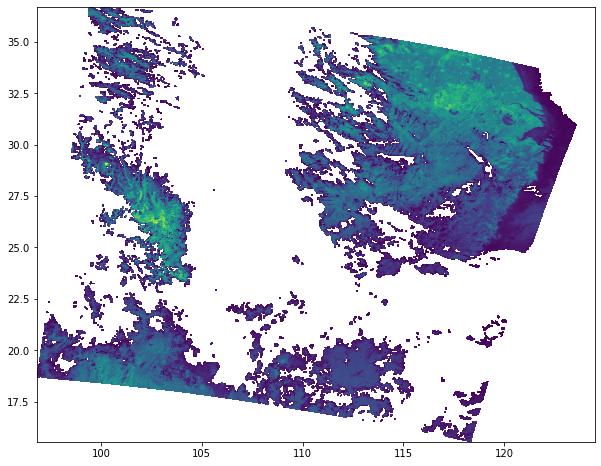

In [25]:
# 对31波段掩膜
C31_clouds_masked=np.ma.masked_where(np.isnan(C31_clouds), C31_clouds)
fig=plt.figure(figsize=(10, 8))
ax=plt.gca()
ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])
image=ax.pcolor(longitude, latitude, C31_clouds_masked)

In [26]:
# 定义普朗克函数
def planckInvert(wavel,Llambda):
    """input wavelength in microns and Llambda in W/m^2/micron/sr, output
    output brightness temperature in K  (note that we've remove the factor
    of pi because we are working with radiances, not fluxes)
    """
    c=2.99792458e+08  #m/s -- 光速
    h=6.62606876e-34  #J s  -- 普朗克常数
    kb=1.3806503e-23  # J/K  -- 玻尔兹曼常数
    c1=2.*h*c**2.
    c2=h*c/kb

    Llambda=Llambda*1.e6  #转换到 W/m^2/m/sr
    wavel=wavel*1.e-6  #波长转换到m
    Tbright=c2/(wavel*np.log(c1/(wavel**5.*Llambda) + 1.))
    
    return Tbright

In [27]:
# 反演
cloud_Tbright=planckInvert(11.02, C31_clouds)

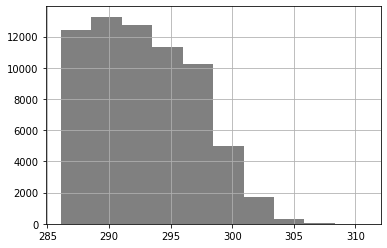

In [28]:
# 直方图
plt.hist(cloud_Tbright[~np.isnan(cloud_Tbright)].flat, color='gray')
plt.grid()

In [29]:
# 掩膜反演的结果
cloud_Tbright_masked=np.ma.masked_where(np.isnan(cloud_Tbright), cloud_Tbright)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  after removing the cwd from sys.path.
D:\ProgramData\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3377: RuntimeWarning: invalid value encountered in greater
  x = ma.masked_values(np.where(x > 1.e20,1.e20,x), 1.e20)


Text(0.5, 1.0, 'Land Surface Temperature\n channel-31 ')

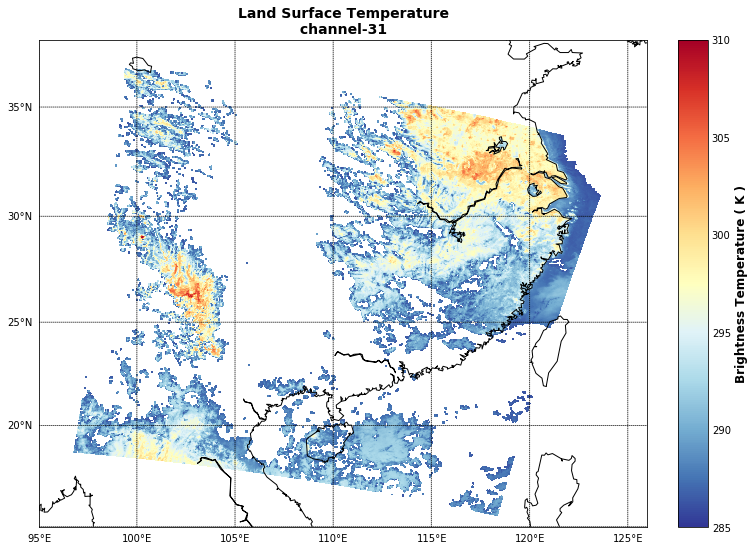

In [30]:
# 制图
CMap=plt.cm.RdYlBu_r
proj=Basemap(resolution='l', projection='mill',\
             lat_1=10, lat_2=60, lat_0=32, lon_0=-140,llcrnrlon=95, llcrnrlat=15, urcrnrlon=126, urcrnrlat=38)
fig=plt.figure(figsize=(12, 12))
ax=plt.gca()
parallels=np.arange(-90, 90, 5)
meridians=np.arange(0, 360, 5)
proj.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=10, latmax=90)
proj.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=10, latmax=90)
proj.drawcoastlines(linewidth=1.0, linestyle='solid', color='k')
x, y=proj(longitude, latitude)
CS=proj.pcolor(x, y, cloud_Tbright_masked, cmap=CMap, vmin=285, vmax=310)
CBar=proj.colorbar(CS, 'right', size='5%', pad='5%')
CBar.set_label('Brightness Temperature ( K )', fontsize=12, fontweight='bold')
CBar.ax.tick_params(axis='y', length=0)
ax.set_title('Land Surface Temperature\n channel-31 ',fontweight='bold',fontsize=14)


In [ ]:
# 保存图片
plt.savefig('Land Surface Temperature.png', dpi=250, facecolor='w', edgecolor='w',
            orientation='portrait', papertype='a4', format='png',
            transparent=True, bbox_inches='tight', pad_inches=0,
          frameon=None)